**SET PATH**

In [3]:
 # Put file path as a string here

CIFAR_DIR = 'CIFAR_10_DATA/'

In [4]:
def unpickle(file):
    import pickle
    with open(file, 'rb') as fo:
        cifar_dict = pickle.load(fo, encoding='bytes')
    return cifar_dict

**LOAD THE DATASET**

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [6]:
CIFAR_DIR = 'drive/MyDrive/ADTA 5550/'

In [7]:
dirs = ['batches.meta','data_batch_1','data_batch_2','data_batch_3','data_batch_4','data_batch_5','test_batch']

all_data = [0,1,2,3,4,5,6]

for i,direc in zip(all_data,dirs):
    all_data[i] = unpickle(CIFAR_DIR+direc)

In [8]:
batch_meta = all_data[0]
data_batch1 = all_data[1]
data_batch2 = all_data[2]
data_batch3 = all_data[3]
data_batch4 = all_data[4]
data_batch5 = all_data[5]
test_batch = all_data[6]

**Examples of images using matplotlib**

In [9]:
import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np

In [10]:
X = data_batch1[b"data"] 

In [11]:
X = X.reshape(10000, 3, 32, 32).transpose(0,2,3,1).astype("uint8")

In [12]:
X[0].max()

255

In [13]:
(X[0]/255).max()

1.0

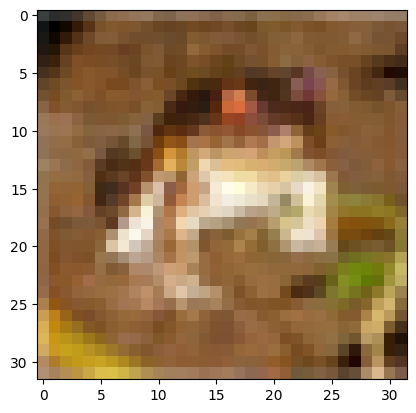

In [14]:
plt.imshow(X[0])

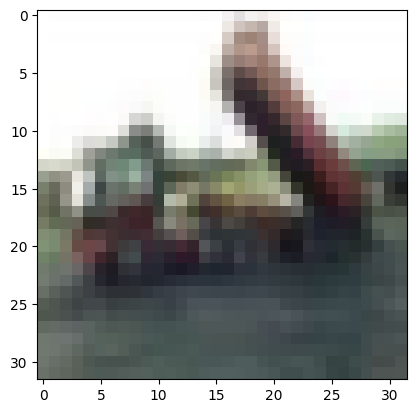

In [15]:
plt.imshow(X[2])

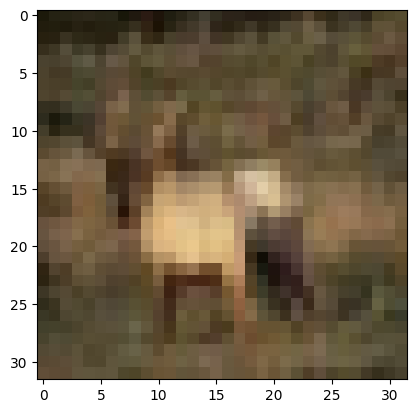

In [16]:
plt.imshow(X[3])

**Encode labels into One-Hot**

In [17]:
def one_hot_encode(vec, vals=10):
    '''
    For use to one-hot encode the 10- possible labels
    '''
    n = len(vec)
    out = np.zeros((n, vals))
    out[range(n), vec] = 1
    return out

**Setting up the image data for first conv layer**

In [18]:
class CifarHelper():
    
    def __init__(self):
        self.i = 0
        
        self.all_train_batches = [data_batch1,data_batch2,data_batch3,data_batch4,data_batch5]
        self.test_batch = [test_batch]
        
        self.training_images = None
        self.training_labels = None
        
        self.test_images = None
        self.test_labels = None
    
    def set_up_images(self):
        
        print("Setting Up Training Images and Labels")
        
        self.training_images = np.vstack([d[b"data"] for d in self.all_train_batches])
        train_len = len(self.training_images)
        
        self.training_images = self.training_images.reshape(train_len,3,32,32).transpose(0,2,3,1)/255
        self.training_labels = one_hot_encode(np.hstack([d[b"labels"] for d in self.all_train_batches]), 10)
        
        print("Setting Up Test Images and Labels")
        
        self.test_images = np.vstack([d[b"data"] for d in self.test_batch])
        test_len = len(self.test_images)
        
        self.test_images = self.test_images.reshape(test_len,3,32,32).transpose(0,2,3,1)/255
        self.test_labels = one_hot_encode(np.hstack([d[b"labels"] for d in self.test_batch]), 10)

        
    def next_batch(self, batch_size):
        x = self.training_images[self.i:self.i+batch_size].reshape(100,32,32,3)
        y = self.training_labels[self.i:self.i+batch_size]
        self.i = (self.i + batch_size) % len(self.training_images)
        return x, y

**Calling CifarHelper.set_up_images()** 

In [19]:
# Before Your tf.Session run these two lines
ch = CifarHelper()
ch.set_up_images()

# During your session to grab the next batch use this line
# (Just like we did for mnist.train.next_batch)
# batch = ch.next_batch(100)

Setting Up Training Images and Labels
Setting Up Test Images and Labels


**Building Convolutional Neural Network**

In [20]:
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()

Instructions for updating:
non-resource variables are not supported in the long term


**Creating Placeholders for inputs x and y**

In [21]:
# PLACEHOLDER

# Create a placeholder for the inputs data: x
# x: a 2D array
# x: a placeholder that can hold any number of rows/record


# Create a placeholder for a tensor with shape [None, 10]
x = tf.placeholder(tf.float32, shape=[None, 32, 32, 3])
import warnings
# Ignore all warnings
warnings.filterwarnings("ignore")
# x = tf.placeholder(tf.float32, shape=[None, 32, 32, 3])

In [22]:
# PLACEHOLDER

# Create a placeholder for the labels of the inputs data: y_true
# y_true: a 2D array
# y_true: Can hold any number of rows/records

y_true = tf.placeholder(tf.float32, [None, 10])

In [23]:
# No need to reshape the data 
# DO NOTHING -- DON'T NEED TO RESHAPE - DATA IS ALREADY IN GOOD SHAPE TO BE FED INTO 1ST CONVOLUTION LAYER

**Train and Test CNN model on CIFAR_10 dataset**

In [24]:
# Define the CNN model architecture
def cnn_model_fn(features, labels, mode):
    # Input Layer
    input_layer = tf.reshape(features, [-1, 32, 32, 3])

    # Convolutional Layer #1
    conv1 = tf.layers.conv2d(
        inputs=input_layer,
        filters=32,
        kernel_size=[5, 5],
        padding="same",
        activation=tf.nn.relu)

    # Pooling Layer #1
    pool1 = tf.layers.max_pooling2d(inputs=conv1, pool_size=[2, 2], strides=2)

    # Convolutional Layer #2
    conv2 = tf.layers.conv2d(
        inputs=pool1,
        filters=64,
        kernel_size=[5, 5],
        padding="same",
        activation=tf.nn.relu)

    # Pooling Layer #2
    pool2 = tf.layers.max_pooling2d(inputs=conv2, pool_size=[2, 2], strides=2)

    # Dense Layer
    pool2_flat = tf.reshape(pool2, [-1, 8 * 8 * 64])
    dense = tf.layers.dense(inputs=pool2_flat, units=1024, activation=tf.nn.relu)
    dropout = tf.layers.dropout(inputs=dense, rate=0.4, training=mode == tf.estimator.ModeKeys.TRAIN)

    # Logits Layer
    logits = tf.layers.dense(inputs=dropout, units=10)

    predictions = {
        "classes": tf.argmax(input=logits, axis=1),
        "probabilities": tf.nn.softmax(logits, name="softmax_tensor")
    }

    # Prediction Mode
    if mode == tf.estimator.ModeKeys.PREDICT:
        return tf.estimator.EstimatorSpec(mode=mode, predictions=predictions)

    # Calculate Loss (for both TRAIN and EVAL modes)
    loss = tf.losses.softmax_cross_entropy(onehot_labels=labels, logits=logits)

    # Training Mode
    if mode == tf.estimator.ModeKeys.TRAIN:
        optimizer = tf.train.AdamOptimizer(learning_rate=0.001)
        train_op = optimizer.minimize(loss=loss, global_step=tf.train.get_global_step())
        return tf.estimator.EstimatorSpec(mode=mode, loss=loss, train_op=train_op)

    # Evaluation Mode
    eval_metric_ops = {
        "accuracy": tf.metrics.accuracy(labels=tf.argmax(input=labels, axis=1), predictions=predictions["classes"])
    }
    return tf.estimator.EstimatorSpec(mode=mode, loss=loss, eval_metric_ops=eval_metric_ops)


In [25]:
# Create the Estimator
cifar_classifier = tf.estimator.Estimator(
    model_fn=cnn_model_fn, model_dir="/tmp/cifar_convnet_model")



Instructions for updating:
Use tf.keras instead.
Instructions for updating:
Use tf.keras instead.


In [27]:
# Define the training input function
warnings.filterwarnings("ignore")
train_input_fn = tf.estimator.inputs.numpy_input_fn(
    x=ch.training_images,
    y=ch.training_labels,
    batch_size=100,
    num_epochs=None,
    shuffle=True)

# Train the classifier for 2000 steps, testing after every 100 steps
warnings.filterwarnings("ignore")
for step in range(1, 21):
    cifar_classifier.train(
        input_fn=train_input_fn,
        steps=100)

    # Test the classifier
    # Evaluate the classifier on the test set after every 100 steps of training
    if step % 1 == 0:
        test_input_fn = tf.estimator.inputs.numpy_input_fn(
            x=ch.test_images,
            y=ch.test_labels,
            num_epochs=1,
            shuffle=False)
        eval_results = cifar_classifier.evaluate(input_fn=test_input_fn)
        print(f"Step {step}, Test Accuracy: {eval_results['accuracy']}")

Instructions for updating:
Use standard file APIs to delete files with this prefix.
Instructions for updating:
Use tf.keras instead.


Step 1, Test Accuracy: 0.7175999879837036
Step 2, Test Accuracy: 0.7099000215530396
Step 3, Test Accuracy: 0.7084000110626221
Step 4, Test Accuracy: 0.7141000032424927
Step 5, Test Accuracy: 0.7193999886512756
Step 6, Test Accuracy: 0.7275000214576721
Step 7, Test Accuracy: 0.7149999737739563
Step 8, Test Accuracy: 0.7121999859809875
Step 9, Test Accuracy: 0.7246999740600586
Step 10, Test Accuracy: 0.7196999788284302
Step 11, Test Accuracy: 0.7156000137329102
Step 12, Test Accuracy: 0.7245000004768372
Step 13, Test Accuracy: 0.7125999927520752
Step 14, Test Accuracy: 0.7135000228881836
Step 15, Test Accuracy: 0.7159000039100647
Step 16, Test Accuracy: 0.7095999717712402
Step 17, Test Accuracy: 0.7279000282287598
Step 18, Test Accuracy: 0.7253000140190125
Step 19, Test Accuracy: 0.7243000268936157
Step 20, Test Accuracy: 0.729200005531311


In [28]:
# Define the test input function
test_input_fn = tf.estimator.inputs.numpy_input_fn(
    x=ch.test_images,
    y=ch.test_labels,
    num_epochs=1,
    shuffle=False)

# Evaluate the classifier on the test set
eval_results = cifar_classifier.evaluate(input_fn=test_input_fn)
print(f"Test Accuracy: {eval_results['accuracy']}")

Test Accuracy: 0.729200005531311
